### makemore: becoming a backprop ninja

swole doge style

In [1]:
# there is no change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('../assets/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# ok boilerplate done, now we get to the action:

In [7]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1 # using b1 just for fun, it's useless because of
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializing with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the charcters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(dim=0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correlation (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't backprop ro be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3523, grad_fn=<NegBackward0>)

In [11]:
logprobs.shape

torch.Size([32, 27])

In [12]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [13]:
logprobs[range(n), Yb]

tensor([-3.8851, -3.0230, -3.6687, -3.1395, -4.1178, -3.4430, -3.1365, -3.9822,
        -3.3985, -4.3354, -3.0911, -1.7253, -2.7878, -2.8255, -3.0329, -3.2129,
        -3.8827, -3.0824, -3.6249, -3.3303, -2.8791, -3.0892, -4.3874, -4.0887,
        -3.3916, -2.8201, -2.9274, -4.1365, -2.9650, -3.4239, -3.2808, -3.1587],
       grad_fn=<IndexBackward0>)

In [14]:
logprobs[range(n), Yb].shape

torch.Size([32])

In [15]:
# loss = - (a + b + c) / 3
# dloss/da = -1/3 generally -1/n

In [16]:
# ---------logprobs done.-------

In [17]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [18]:
# c = a * b, but with tensors
# a[3x3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3x3]

In [19]:
# a11 a12 a13  ---> b1 (= a11 + a12 + a13)
# a21 a22 a23  ---> b2 (= a21 + a22 + a23)
# a31 a32 a33  ---> b3 (= a31 + a32 + a33)

In [20]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [21]:
# c11 c12 c13 = a11 a12 a13    b1
# c21 c22 c23 = a21 a22 a23  - b2
# c31 c32 c33 = a31 a32 a33    b3

# so e.g. c32 = a32 - b3

In [24]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [25]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [26]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [27]:
bnvar.shape, bndiff.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [28]:
# a11 a12
# a21 a22
# --->
# b1 b2 where:
# b1 = 1/(n-1)*(a11 + a21)
# b2 = 1/(n-1)*(a12 + a22)

In [29]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [30]:
# forward pass: hprebn = embcat @ W1 + b1
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [31]:
# forward pass: embcat = emb.view(emb.shape[0], -1)
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [32]:
# forward pass: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [33]:
Xb.view(-1, 1).shape, Xb.view(-1, 1).expand(-1, C.shape[1]).shape

(torch.Size([96, 1]), torch.Size([96, 10]))

In [23]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = (1.0 / probs) * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)

dcounts = counts_sum_inv * dprobs

dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv 

dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = counts * dcounts # so we already calculated norm_logits.exp() in counts we can reuse that

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(dim=1, keepdim=True)
dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes
"""
we can also do like this for dlogits
step = torch.zeros_like(logits)
step[range(n), logits.max(dim=1).indices] = 1
dlogits += step * dlogit_maxes
"""

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(dim=0)

dhpreact = (1.0 - h**2) * dh

dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(dim=0, keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)

dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

dbndiff2 =  (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2

dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(dim=0, keepdim=True)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(dim=0)

demb = dembcat.view(emb.shape)

# dC = torch.zeros_like(C)
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k, j]
#         dC[ix] += demb[k, j]

# vectorizing the above loop
dC = torch.zeros_like(C)
ix = Xb.reshape(-1) # (32*3, ) ---> (96, )
vals = demb.reshape(-1, C.shape[1]) # (32*3, 10) ---> (96, 10)
dC.scatter_add_(0, ix[:, None].expand(-1, C.shape[1]), vals)

# one liner using .view
dC = torch.zeros_like(C).scatter_add_(0,
                                      Xb.view(-1, 1).expand(-1, C.shape[1]),
                                      demb.view(-1, C.shape[1])
                                     )

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)

cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bndiff', dbndiff, bndiff)

cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)

cmp('bndiff', dbndiff, bndiff)

cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)

cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [34]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss
# take the derivative, simply the expression, and just writr it out

# forward pass

# before
# logit_maxes = logits.max(dim=1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(dim=1, keepdim=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't backprop ro be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3523049354553223 diff: 4.76837158203125e-07


In [35]:
# backward pass

dlogits = F.softmax(logits, dim=1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [36]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [37]:
F.softmax(logits, dim=1)[0]

tensor([0.0690, 0.0888, 0.0175, 0.0474, 0.0214, 0.0746, 0.0237, 0.0376, 0.0205,
        0.0327, 0.0367, 0.0372, 0.0344, 0.0300, 0.0372, 0.0139, 0.0095, 0.0203,
        0.0162, 0.0546, 0.0492, 0.0235, 0.0264, 0.0728, 0.0585, 0.0267, 0.0196],
       grad_fn=<SelectBackward0>)

In [38]:
dlogits[0] * n

tensor([ 0.0690,  0.0888,  0.0175,  0.0474,  0.0214,  0.0746,  0.0237,  0.0376,
        -0.9795,  0.0327,  0.0367,  0.0372,  0.0344,  0.0300,  0.0372,  0.0139,
         0.0095,  0.0203,  0.0162,  0.0546,  0.0492,  0.0235,  0.0264,  0.0728,
         0.0585,  0.0267,  0.0196], grad_fn=<MulBackward0>)

In [39]:
dlogits[0].sum() # it actually sums to zero

tensor(-3.2596e-09, grad_fn=<SumBackward0>)

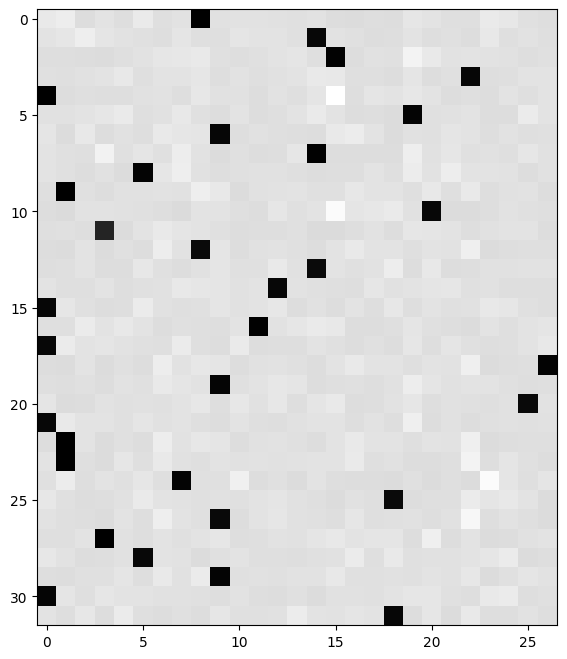

In [40]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [41]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. it's input, simply the expression, and just write it out

# forward pass

# before
# bnmeani = 1/n*hprebn.sum(dim=0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(dim=0, keepdim=True) # note: Bessel's correlation (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(dim=0, keepdim=True)) / torch.sqrt(hprebn.var(dim=0, keepdim=True, unbiased=True))
print('max_diff:', (hpreact_fast - hpreact).abs().max())

max_diff: tensor(0.2511, grad_fn=<MaxBackward1>)


In [42]:
# dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
# dbnraw = bngain * dhpreact
# dbnbias = dhpreact.sum(dim=0, keepdim=True)

# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(dim=0, keepdim=True)

# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

# dbndiff2 =  (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2 * bndiff) * dbndiff2

# dhprebn = dbndiff.clone()
# dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(dim=0, keepdim=True)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
# calculate dhprebn given dhpreact (i.e backprop through batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)
dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(dim=0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(dim=0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [66]:
# Exercise 4: putting it all together
# Train the MLP neural net with your own backward pass

# init
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed),             generator=g)
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden,                         generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as the last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use the context manager for efficiency once your backward pass is written in (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):
    
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------------
        bnmean = hprebn.mean(dim=0, keepdim=True)
        bnvar = hprebn.var(dim=0, keepdim=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function
    
        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward() # use this for correctness comparisions, delete it later
    
        # manual backprop! #swole_doge_meme
        # ------------------
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(dim=0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(dim=0, keepdim=True)
        dbnbias = dhpreact.sum(dim=0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(dim=0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(dim=0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k, j]
                dC[ix] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # ------------------
    
        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable
    
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    
        # if i >= 100: # TODO: delete breaking when you're ready to train the full net
        #     break

12297
      0/ 200000: 3.7898
  10000/ 200000: 2.1887
  20000/ 200000: 2.3943
  30000/ 200000: 2.4331
  40000/ 200000: 1.9925
  50000/ 200000: 2.3507
  60000/ 200000: 2.3578
  70000/ 200000: 2.0634
  80000/ 200000: 2.3028
  90000/ 200000: 2.1597
 100000/ 200000: 1.9771
 110000/ 200000: 2.3632
 120000/ 200000: 1.9485
 130000/ 200000: 2.4824
 140000/ 200000: 2.2720
 150000/ 200000: 2.1919
 160000/ 200000: 2.0191
 170000/ 200000: 1.8115
 180000/ 200000: 1.9773
 190000/ 200000: 1.8975


In [63]:
# useful for checking your gradients
# for p, g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.1175870895385742e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [67]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnvar = hpreact.var(dim=0, keepdim=True, unbiased=True)

In [68]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695319175720215
val 2.1098694801330566


In [69]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # -------------
        # forward pass:
        # Embedding
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # --------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))
        

mona.
mayah.
see.
mad.
ryla.
reisha.
ejdraegan.
ched.
elin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shubergihimie.
trick.
welle.
joseulfouna.
geder.
